# Forest Area Analysis: Exploring Socio-Economic Drivers in India and the United States

This notebook investigates the relationship between forest area and key socio-economic factors, including GDP per capita, population density, and urbanization. We use Bayesian regression models to quantify these relationships and focuses on comparing the trends observed in India and the United States. The analysis is structered in stages: first examining the influence o fGDP per Capita on forest area, then incoporating population density and finally urbanization

## Importing Libraries

This cell imports necessary libraries for data manipulation, visualization, and Bayesian modeling. We'll utilize pandas, matplotlib, and seaborn for data manipulation and visualization. For building and analyzing our Bayesian models, we'll leverage pymc and arviz. And xarray will aid in working with multi-dimensional data within our models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import xarray as xr
import pymc as pm
from pymc import Normal, HalfNormal

# Loading DataSet
Now, let's load and prepare our data. We'll be working with datasets containing information on GDP per capita, forest area

**Loading GDP dataset**

In [4]:
gdp_df = pd.read_csv("gdp-per-capita-maddison.csv");
gdp_df

,Entity,Code,Year,GDP per capita,900793-annotations
0,Afghanistan,AFG,1950,1156.0000,NaN
1,Afghanistan,AFG,1951,1170.0000,NaN
2,Afghanistan,AFG,1952,1189.0000,NaN
3,Afghanistan,AFG,1953,1240.0000,NaN
4,Afghanistan,AFG,1954,1245.0000,NaN
...,...,...,...,...,...
21581,Zimbabwe,ZWE,2018,1900.1992,NaN
21582,Zimbabwe,ZWE,2019,1753.0244,NaN
21583,Zimbabwe,ZWE,2020,1585.9728,NaN
21584,Zimbabwe,ZWE,2021,1687.2532,NaN


**Loading Forest Dataset**

In [7]:
forest_df = pd.read_csv("forestation.csv")
forest_df.columns = ["Code", "Entity", "Year", "Forest Area"]
forest_df

,Code,Entity,Year,Forest Area
0,ABW,Aruba,1990,4.200000
1,AFG,Afghanistan,1990,13500.000000
2,AGO,Angola,1990,609760.000000
3,ALB,Albania,1990,7887.999878
4,AND,Andorra,1990,160.000000
...,...,...,...,...
7123,XKX,Kosovo,2016,NaN
7124,YEM,"Yemen, Rep.",2016,5490.000000
7125,ZAF,South Africa,2016,92410.000000
7126,ZMB,Zambia,2016,484683.984375


# Processing DataSet
- We merge these DataFrames based on 'Entity' (the country) and 'Year' to create a unified dataset for analysis.
- We'll also address any missing data points to ensure the reliability of our analysis. For example, we'll fill in missing values for Ethiopia's forest area using the mean for that country.


**Merging two datasets by *Entity* and *Year***

In [11]:
merged_df = pd.merge(gdp_df, forest_df, on=['Entity', 'Year'], how='inner')
merged_df

,Entity,Code_x,Year,GDP per capita,900793-annotations,Code_y,Forest Area
0,Afghanistan,AFG,1990,963.00000,NaN,AFG,13500.000000
1,Afghanistan,AFG,1991,881.17040,NaN,AFG,13500.000000
2,Afghanistan,AFG,1992,843.87537,NaN,AFG,13500.000000
3,Afghanistan,AFG,1993,578.40280,NaN,AFG,13500.000000
4,Afghanistan,AFG,1994,428.42456,NaN,AFG,13500.000000
...,...,...,...,...,...,...,...
3913,Zimbabwe,ZWE,2012,1749.85660,NaN,ZWE,149992.001953
3914,Zimbabwe,ZWE,2013,1766.37890,NaN,ZWE,146867.998047
3915,Zimbabwe,ZWE,2014,1789.00480,NaN,ZWE,143744.003906
3916,Zimbabwe,ZWE,2015,1798.78720,NaN,ZWE,140620.000000


**Droping columns that are not required**

In [14]:
merged_df.drop(["900793-annotations", "Code_x", "Code_y"], axis=1, inplace=True)
merged_df

,Entity,Year,GDP per capita,Forest Area
0,Afghanistan,1990,963.00000,13500.000000
1,Afghanistan,1991,881.17040,13500.000000
2,Afghanistan,1992,843.87537,13500.000000
3,Afghanistan,1993,578.40280,13500.000000
4,Afghanistan,1994,428.42456,13500.000000
...,...,...,...,...
3913,Zimbabwe,2012,1749.85660,149992.001953
3914,Zimbabwe,2013,1766.37890,146867.998047
3915,Zimbabwe,2014,1789.00480,143744.003906
3916,Zimbabwe,2015,1798.78720,140620.000000


**Checking information of each column**

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Entity          3918 non-null   object 
 1   Year            3918 non-null   int64  
 2   GDP per capita  3918 non-null   float64
 3   Forest Area     3915 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 122.6+ KB


In [19]:
merged_df.loc[merged_df["Forest Area"].isna()]

,Entity,Year,GDP per capita,Forest Area
1215,Ethiopia,1990,915.0000,NaN
1216,Ethiopia,1991,810.7901,NaN
1217,Ethiopia,1992,708.3693,NaN


In [21]:
merged_df.loc[merged_df["Entity"] == "Ethiopia"]

,Entity,Year,GDP per capita,Forest Area
1215,Ethiopia,1990,915.00000,NaN
1216,Ethiopia,1991,810.79010,NaN
1217,Ethiopia,1992,708.36930,NaN
1218,Ethiopia,1993,699.22723,146912.998047
1219,Ethiopia,1994,731.75090,145504.003906
1220,Ethiopia,1995,744.14180,144095.000000
1221,Ethiopia,1996,782.99414,142685.996094
1222,Ethiopia,1997,815.14545,141277.001953
1223,Ethiopia,1998,786.27900,139867.998047
1224,Ethiopia,1999,761.90326,138459.003906


**Filling missing value of forest area of Ethiopia by mean of that column**

In [24]:
merged_df.fillna({"Forest Area" : merged_df.loc[merged_df["Entity"] == "Ethiopia"]["Forest Area"].mean()}, inplace=True)

In [26]:
merged_df.loc[merged_df["Entity"] == "Ethiopia"]

,Entity,Year,GDP per capita,Forest Area
1215,Ethiopia,1990,915.00000,132296.583252
1216,Ethiopia,1991,810.79010,132296.583252
1217,Ethiopia,1992,708.36930,132296.583252
1218,Ethiopia,1993,699.22723,146912.998047
1219,Ethiopia,1994,731.75090,145504.003906
1220,Ethiopia,1995,744.14180,144095.000000
1221,Ethiopia,1996,782.99414,142685.996094
1222,Ethiopia,1997,815.14545,141277.001953
1223,Ethiopia,1998,786.27900,139867.998047
1224,Ethiopia,1999,761.90326,138459.003906


In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Entity          3918 non-null   object 
 1   Year            3918 non-null   int64  
 2   GDP per capita  3918 non-null   float64
 3   Forest Area     3918 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 122.6+ KB


**Checking unique countrys in dataset**

In [31]:
merged_df["Entity"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Haiti', 'Honduras', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait',
       'Latvia', 'Lebanon', 'Lesotho', '

### Exploring Data: India

Plotting pairplot to see correlations between columns for India.

In [34]:
merged_df_india = merged_df.loc[merged_df["Entity"] == "India"]
merged_df_india

,Entity,Year,GDP per capita,Forest Area
1620,India,1990,2087.0000,639390.000000
1621,India,1991,2062.3103,640841.015625
1622,India,1992,2115.2573,642291.992188
1623,India,1993,2176.4277,643743.007812
1624,India,1994,2254.8990,645193.984375
1625,India,1995,2355.9631,646645.000000
1626,India,1996,2475.5680,648096.015625
1627,India,1997,2514.0217,649546.992188
1628,India,1998,2611.7815,650998.007812
1629,India,1999,2707.7407,652448.984375


Before we move on to modeling, we'll use seaborn to create pair plots for initial data exploration. These visualizations help us see potential correlations between variables, providing valuable insights to guide our model development.

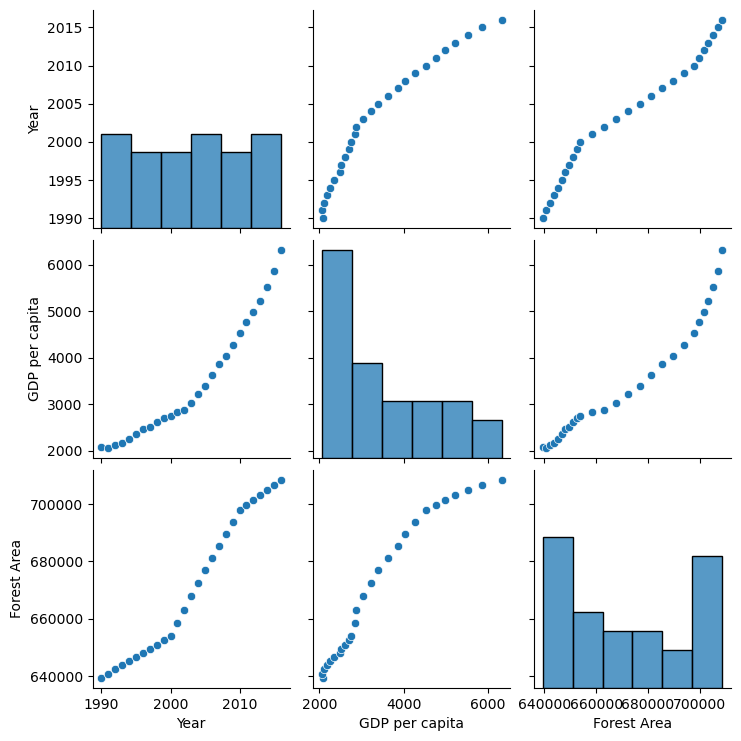

In [37]:
sns.pairplot(merged_df_india)

### Splitting India Data

To prepare for modeling, we'll split India's data into training and testing sets. This is a standard practice in machine learning. We'll use a 60/40 split, allocating 60% of the data for training and the remaining 40% for testing.

In [39]:
split_by = 0.6
train_size_india = int(split_by * merged_df_india.shape[0])
training_india, test_india = merged_df_india.iloc[:train_size_india], merged_df_india.iloc[train_size_india:]

## Bayesian Modeling: India (GDP)

Now we're ready to build our first Bayesian model for India, focusing solely on the relationship between GDP per capita and forest area. We'll define our model using pymc, specifying priors for our model parameters, representing our initial beliefs before considering the data.
We'll use a normal distribution for our likelihood, assuming that forest area can be modeled as a normal distribution with a mean influenced by GDP per capita. The HalfNormal distribution is suitable for the standard deviation, ensuring it remains positive.

In [41]:
with pm.Model() as forest_india_regression_model:
    gdp = pm.Data("gdp", training_india["GDP per capita"], dims="obs")

    # priors
    beta_b = pm.HalfNormal("sigma", sigma=10)
    beta_i = pm.Normal("beta_i", mu=0, sigma=100000)
    beta_gdp = pm.Normal("beta_gdp", mu=0, sigma=1000)

    # likelihood
    pm.Normal("Forest Area", mu=beta_i + beta_gdp * gdp, sigma=beta_b, observed=training_india["Forest Area"], dims="obs")

### Model Simulation and Analysis

Next, we'll simulate our model using Markov Chain Monte Carlo (MCMC) methods to draw samples from the posterior distribution, reflecting our updated knowledge about the model parameters after considering the data.
We'll use diagnostic tools like trace plots and energy plots to assess the convergence of our model, ensuring the sampling process has stabilized. We'll also examine the posterior distributions of our parameters to understand their estimated values and uncertainties.

In [43]:
with forest_india_regression_model:
    idata = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta_i, beta_gdp]


Output()

Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [44]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [45]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_i,582083.747,477.805,581217.144,582981.983,18.195,12.871,691.0,707.0,1.01
beta_gdp,27.463,0.181,27.126,27.800,0.007,0.005,686.0,707.0,1.01
sigma,297.197,5.082,288.231,307.214,0.171,0.121,889.0,768.0,1.00


<Axes: >

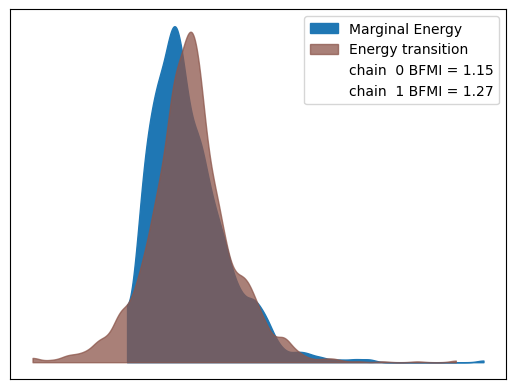

In [46]:
az.plot_energy(idata)

array([[<Axes: title={'center': 'beta_i'}>,
        <Axes: title={'center': 'beta_i'}>],
       [<Axes: title={'center': 'beta_gdp'}>,
        <Axes: title={'center': 'beta_gdp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

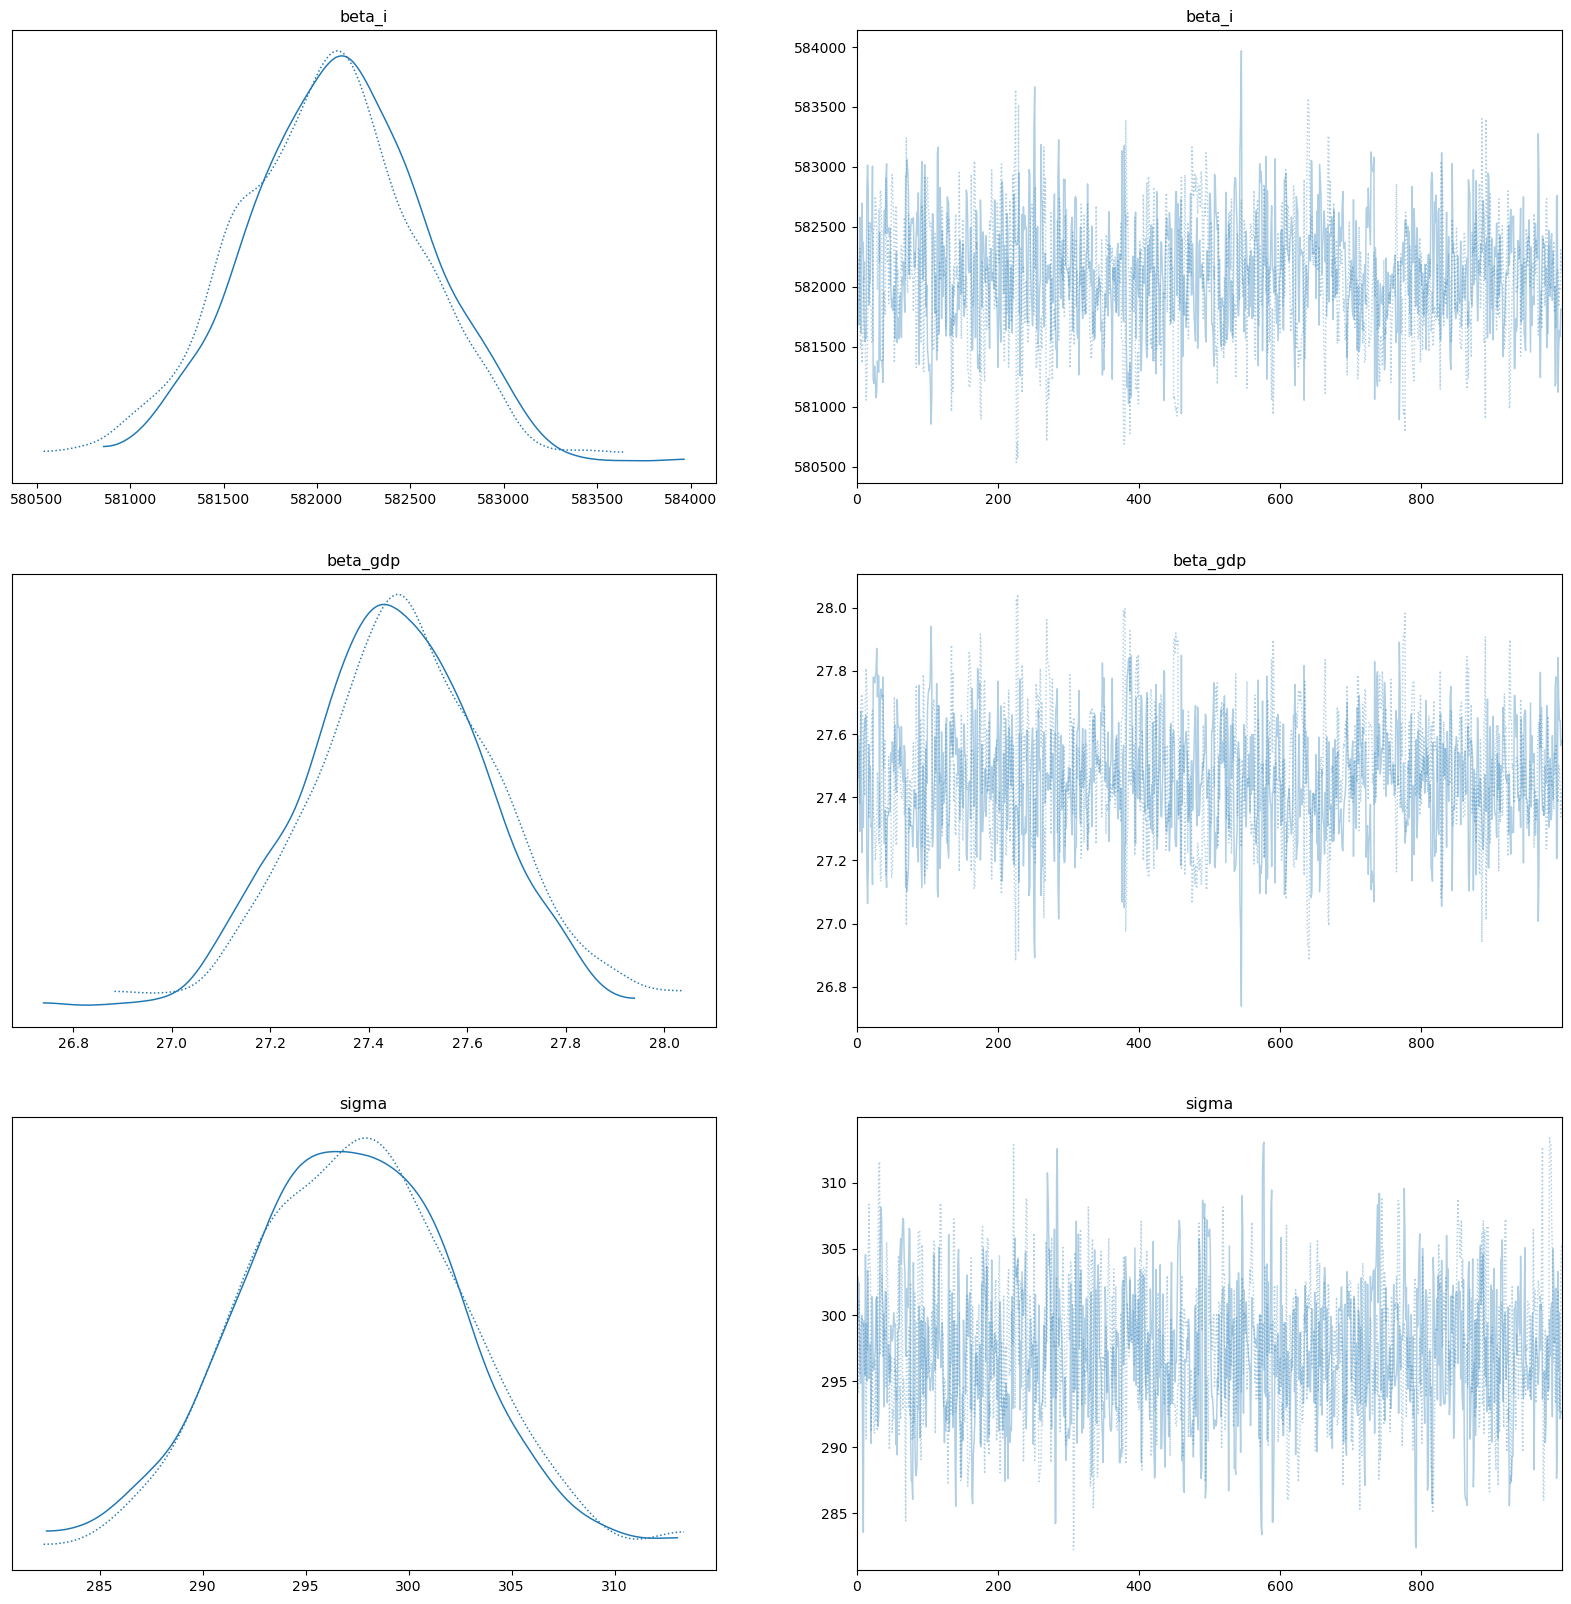

In [47]:
az.plot_trace(idata,figsize=(20,20))

array([<Axes: title={'center': 'beta_i'}>,
       <Axes: title={'center': 'beta_gdp'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

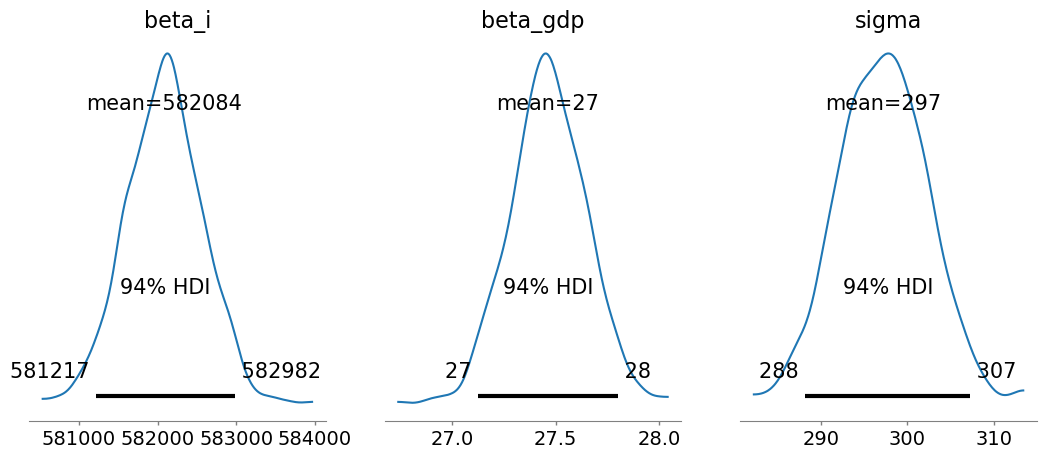

In [50]:
az.plot_posterior(idata, var_names=["beta_i", "beta_gdp", "sigma"], figsize=(13, 5))

### Model Prediction and Evaluation

Having built and analyzed our GDP-focused model for India, we can now use it to make predictions. First, we'll predict forest area for the training data to visualize how well our model fits the observed data.
Next, we'll predict forest area on the test data – data it hasn't seen before – to evaluate the model's generalization ability. We'll assess the model's predictive accuracy by comparing its predictions to the actual forest area values in the test set, giving us a clear picture of how well our GDP-based model predicts forest area in India.

In [53]:
idata.posterior["y_model"] = idata.posterior["beta_i"] + idata.posterior["beta_gdp"] * xr.DataArray(training_india["GDP per capita"])

/opt/anaconda3/lib/python3.12/site-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


Text(0.5, 0, 'x')

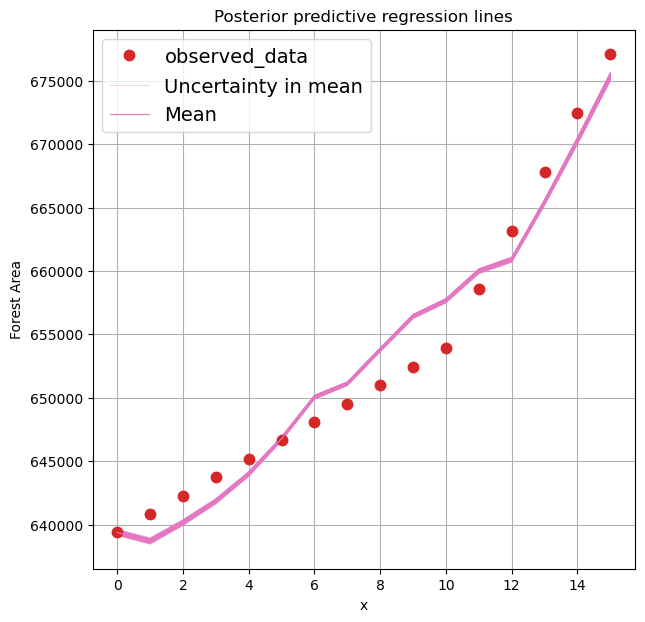

In [54]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="Forest Area", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

### Predicting values for test data (India) using model

In [56]:
with forest_india_regression_model:
    pm.set_data({"gdp" : test_india["GDP per capita"]})
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [Forest Area]


Output()

In [57]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Text(0.5, 0, 'x')

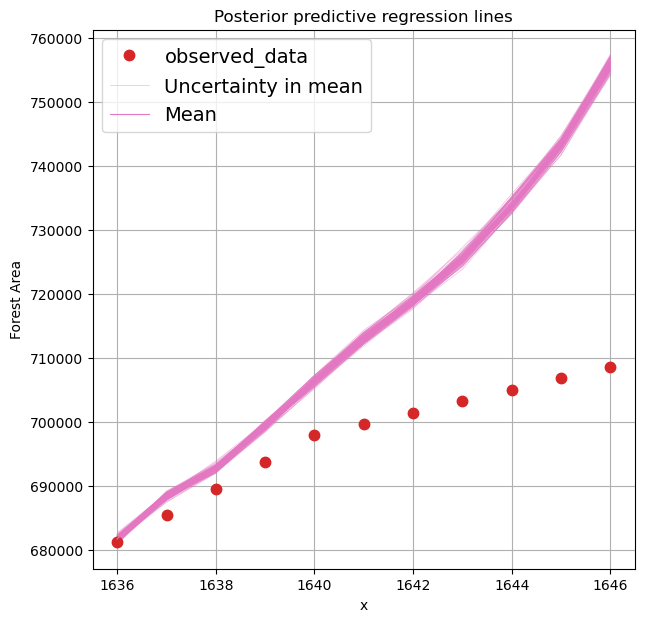

In [58]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(y=test_india["Forest Area"], num_samples=100, axes=ax, y_model=idata.posterior_predictive["Forest Area"])
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

### Exploring Data: United States

Plotting pairplot to see correlations between columns for the United States.

In [60]:
merged_df_usa = merged_df.loc[merged_df["Entity"] == "United States"]
merged_df_usa

,Entity,Year,GDP per capita,Forest Area
3751,United States,1990,36982.000,3.024500e+06
3752,United States,1991,36463.957,3.025586e+06
3753,United States,1992,37240.300,3.026672e+06
3754,United States,1993,37761.535,3.027758e+06
3755,United States,1994,38807.280,3.028844e+06
3756,United States,1995,39390.625,3.029930e+06
3757,United States,1996,40412.750,3.031016e+06
3758,United States,1997,41722.670,3.032102e+06
3759,United States,1998,43072.758,3.033188e+06
3760,United States,1999,44575.848,3.034274e+06


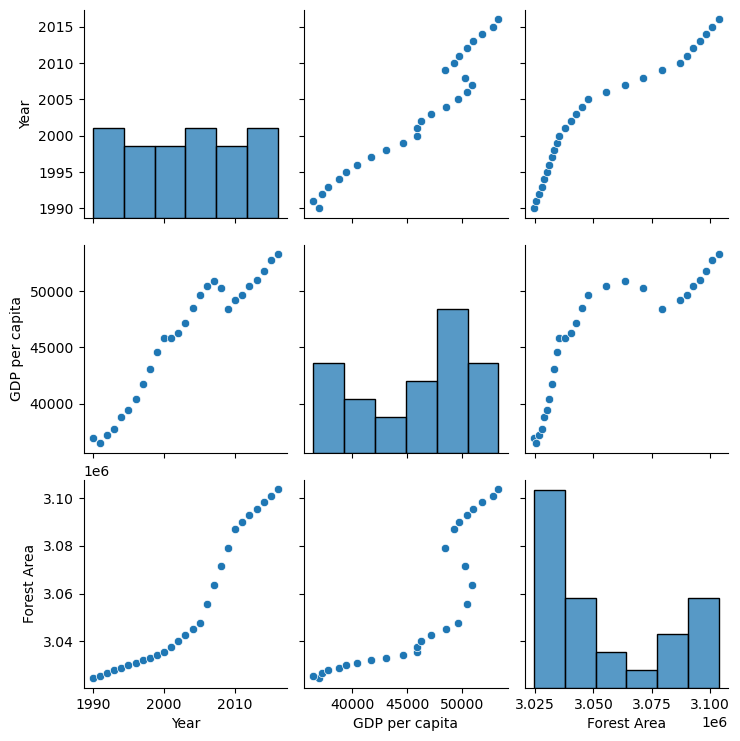

In [61]:
sns.pairplot(merged_df_usa)

### Splitting USA Data

Splitting USA data into training and testing sets.

In [63]:
train_size_usa = int(split_by * merged_df_usa.shape[0])
training_usa, test_usa = merged_df_usa.iloc[:train_size_usa], merged_df_usa.iloc[train_size_usa:]

## Bayesian Modeling: USA (GDP)

Building and simulating a Bayesian regression model for the USA using GDP per capita as a predictor for forest area.### Model Simulation and Analysis

Sampling from the posterior distribution, assessing model convergence

In [65]:
with pm.Model() as forest_usa_regression_model:
    gdp = pm.Data("gdp", training_usa["GDP per capita"], dims="obs")

    # priors
    beta_b = pm.HalfNormal("sigma", sigma=10)
    beta_i = pm.Normal("beta_i", mu=0, sigma=100000)
    beta_gdp = pm.Normal("beta_gdp", mu=0, sigma=1000)

    # likelihood
    pm.Normal("Forest Area", mu=beta_i + beta_gdp * gdp, sigma=beta_b, observed=training_usa["Forest Area"], dims="obs")

### Model Simulation and Analysis

Sampling from the posterior distribution, assessing model convergence, and visualizing results.

In [67]:
with forest_usa_regression_model:
    udata = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta_i, beta_gdp]


Output()

Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [68]:
udata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [69]:
az.summary(udata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_i,2968316.753,651.113,2967043.700,2969535.118,24.673,17.454,702.0,675.0,1.0
beta_gdp,1.544,0.015,1.515,1.573,0.001,0.000,707.0,480.0,1.0
sigma,258.658,5.069,249.310,268.523,0.160,0.113,1005.0,888.0,1.0


<Axes: >

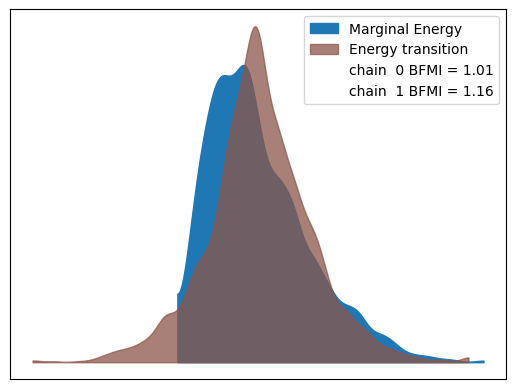

In [70]:
az.plot_energy(udata)

array([[<Axes: title={'center': 'beta_i'}>,
        <Axes: title={'center': 'beta_i'}>],
       [<Axes: title={'center': 'beta_gdp'}>,
        <Axes: title={'center': 'beta_gdp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

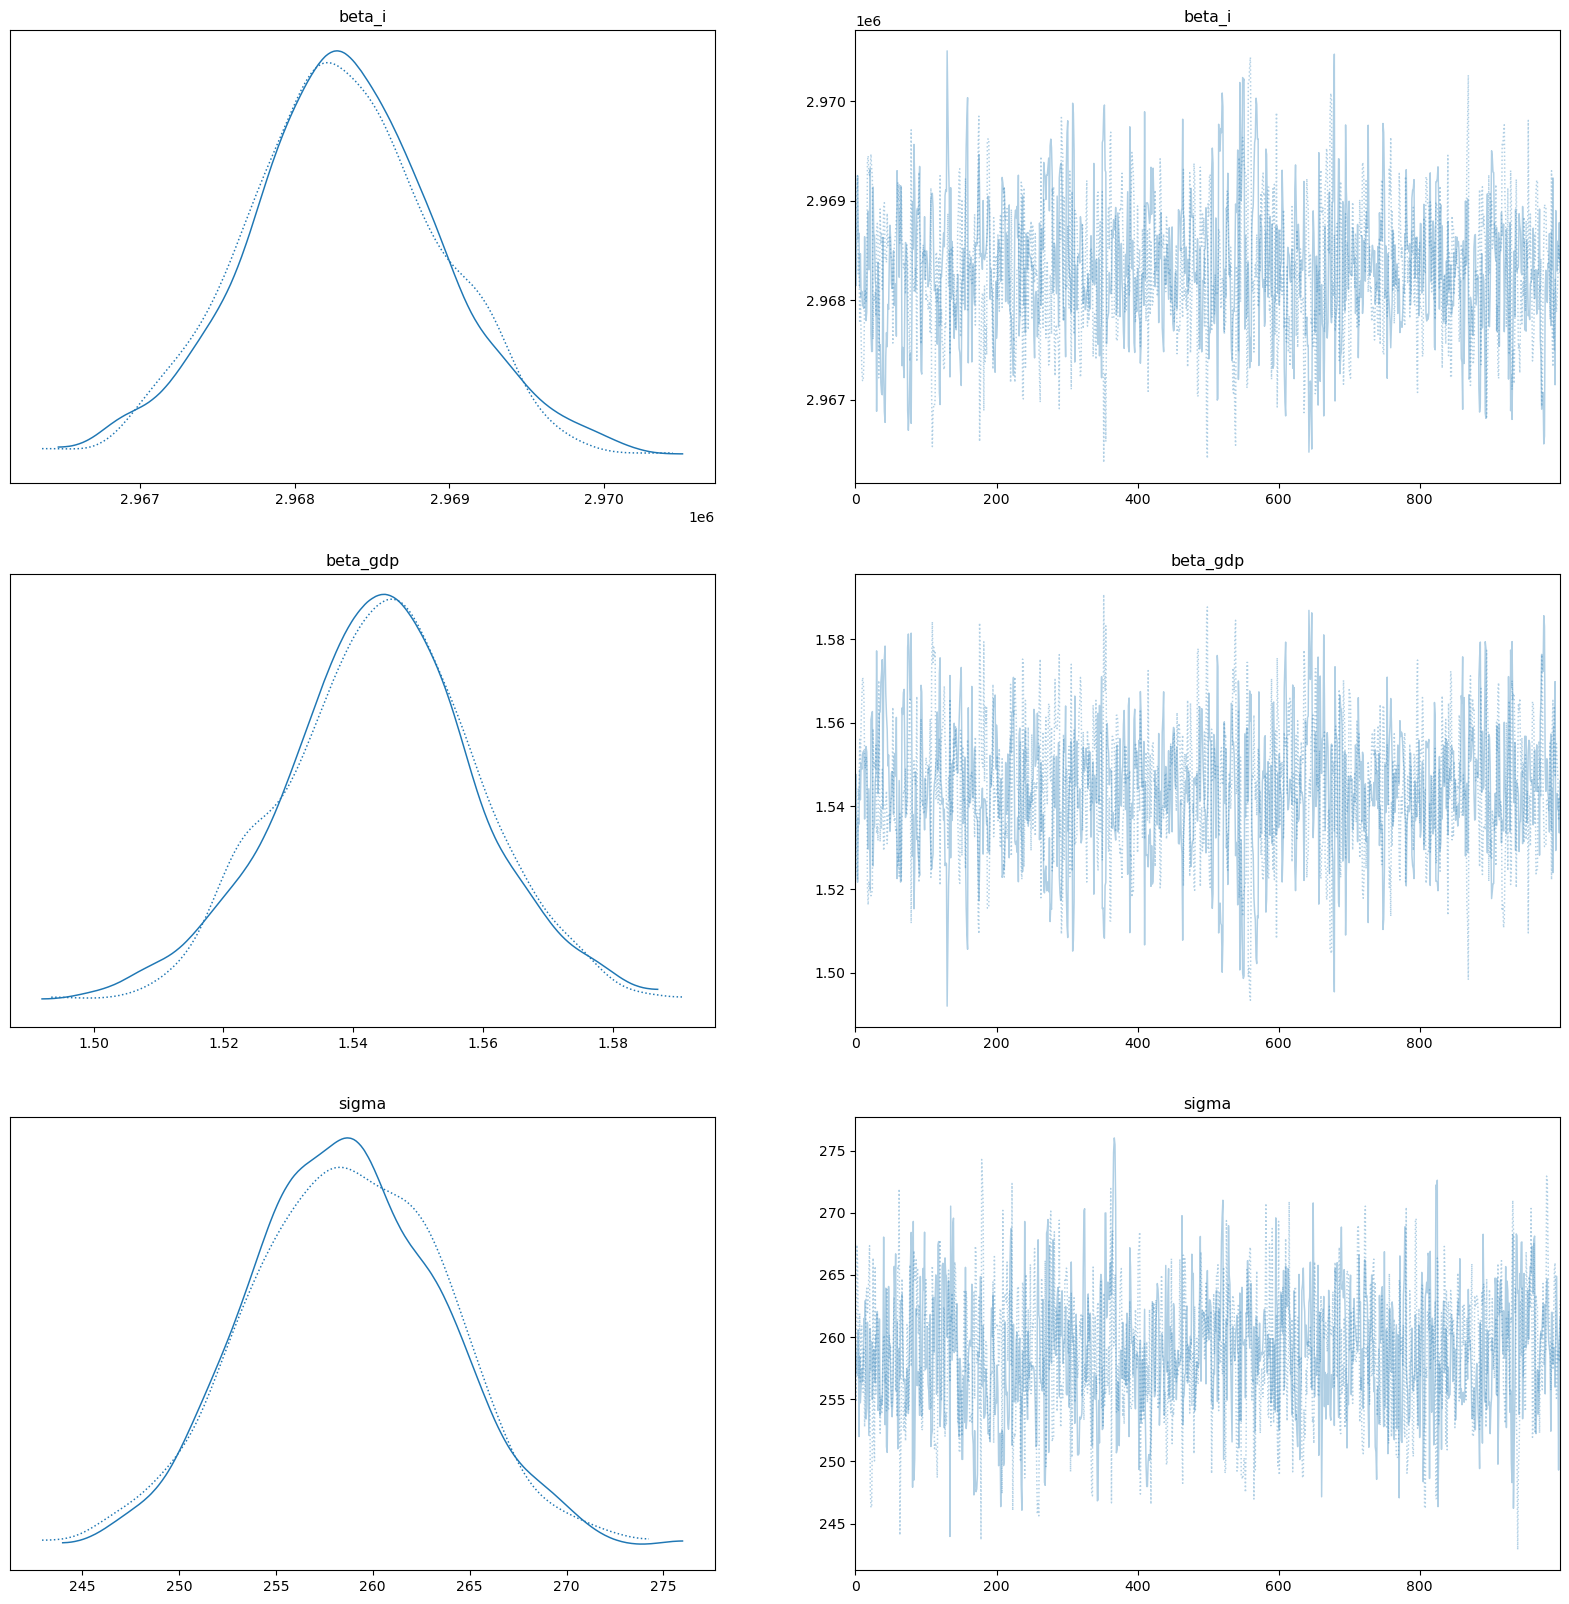

In [71]:
az.plot_trace(udata, figsize=(20, 20))

array([<Axes: title={'center': 'beta_i'}>,
       <Axes: title={'center': 'beta_gdp'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

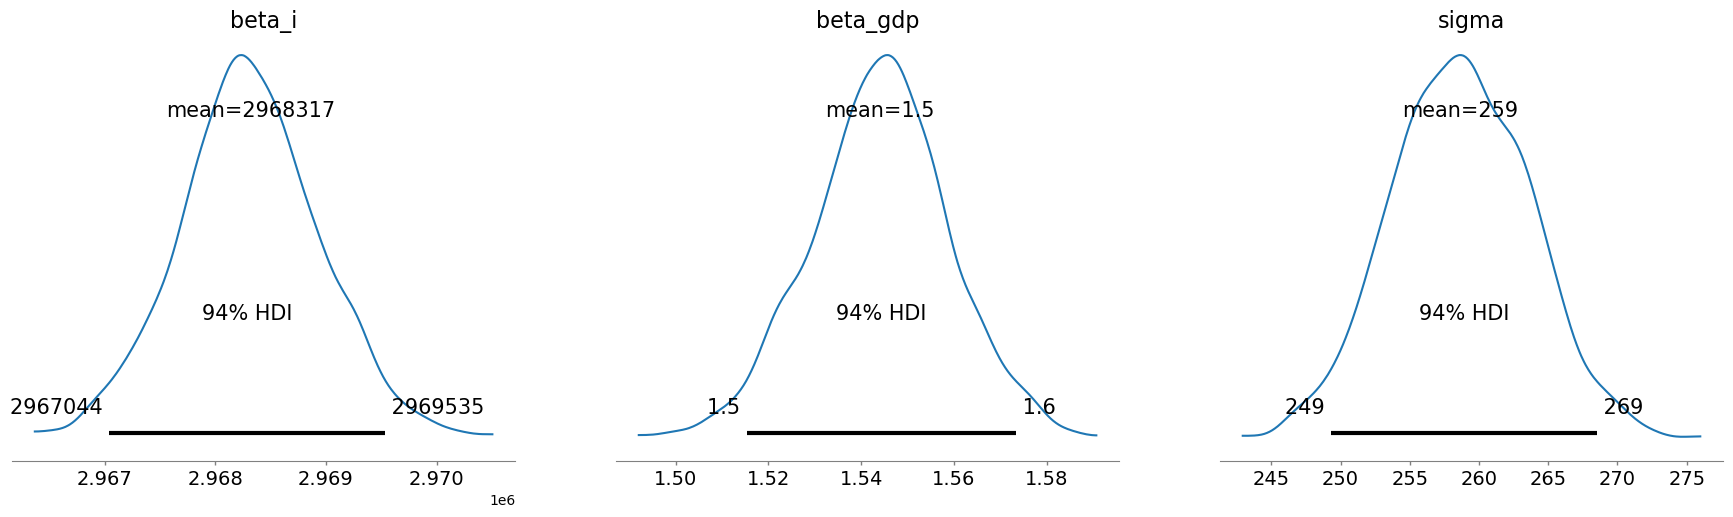

In [72]:
az.plot_posterior(udata, var_names=["beta_i", "beta_gdp", "sigma"])

### Model Prediction and Evaluation

Predicting forest area on the test set and evaluating model performance.

In [74]:
udata.posterior["y_model"] = udata.posterior["beta_i"] + udata.posterior["beta_gdp"] * xr.DataArray(training_usa["GDP per capita"])

/opt/anaconda3/lib/python3.12/site-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


Text(0.5, 0, 'x')

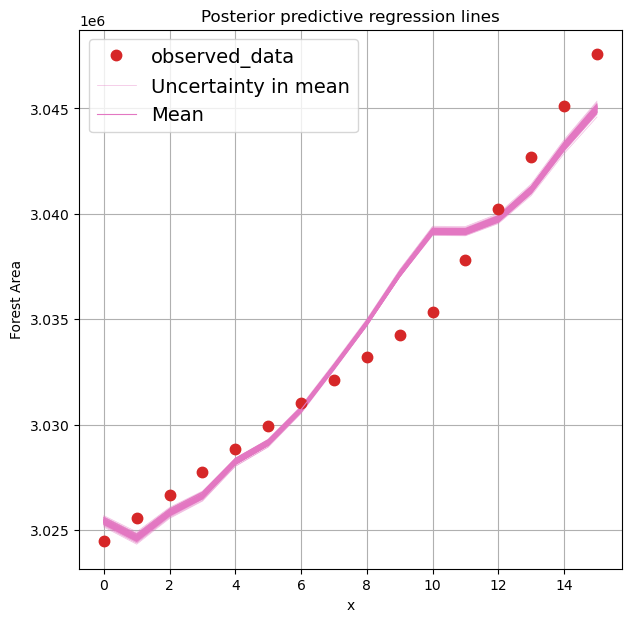

In [75]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=udata, y="Forest Area", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

# Predicting values for test data (Usa) using model

In [77]:
with forest_usa_regression_model:
    pm.set_data({"gdp" : test_usa["GDP per capita"]})
    udata.extend(pm.sample_posterior_predictive(udata))

Sampling: [Forest Area]


Output()

In [78]:
udata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Text(0.5, 0, 'x')

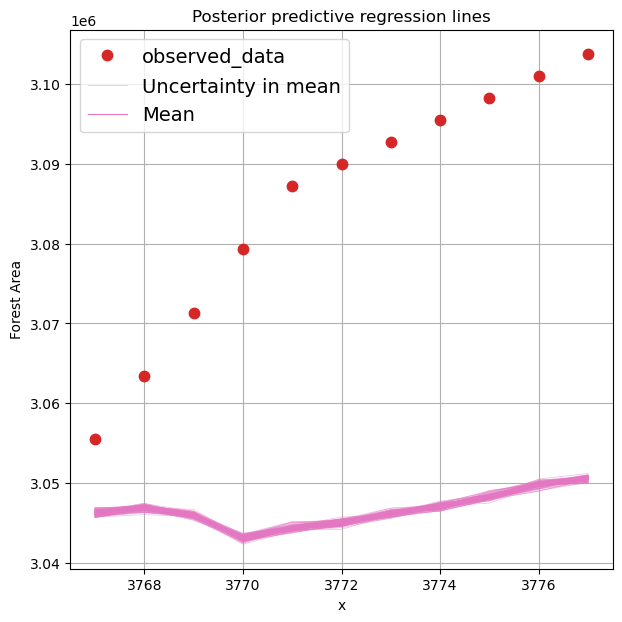

In [79]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(y=test_usa["Forest Area"], num_samples=100, axes=ax, y_model=udata.posterior_predictive["Forest Area"])
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

### Loading Population Density Dataset

In [81]:
population_df = pd.read_csv("population-density.csv")
population_df

,Entity,Code,Year,Population density
0,Afghanistan,AFG,-10000,0.022595
1,Afghanistan,AFG,-9000,0.031285
2,Afghanistan,AFG,-8000,0.043318
3,Afghanistan,AFG,-7000,0.059979
4,Afghanistan,AFG,-6000,0.083047
...,...,...,...,...
76667,Zimbabwe,ZWE,2096,95.231960
76668,Zimbabwe,ZWE,2097,95.469250
76669,Zimbabwe,ZWE,2098,95.695700
76670,Zimbabwe,ZWE,2099,95.893900


### Merging Population Data

Merging population density data with the existing dataset.

In [83]:
added_population_merged__df = pd.merge(merged_df, population_df, on=['Entity', 'Year'], how='inner')
added_population_merged__df

,Entity,Year,GDP per capita,Forest Area,Code,Population density
0,Afghanistan,1990,963.00000,13500.000000,AFG,18.468430
1,Afghanistan,1991,881.17040,13500.000000,AFG,18.764668
2,Afghanistan,1992,843.87537,13500.000000,AFG,20.359354
3,Afghanistan,1993,578.40280,13500.000000,AFG,22.910896
4,Afghanistan,1994,428.42456,13500.000000,AFG,24.915749
...,...,...,...,...,...,...
3913,Zimbabwe,2012,1749.85660,149992.001953,ZWE,35.718975
3914,Zimbabwe,2013,1766.37890,146867.998047,ZWE,36.225437
3915,Zimbabwe,2014,1789.00480,143744.003906,ZWE,36.725777
3916,Zimbabwe,2015,1798.78720,140620.000000,ZWE,37.221170


### Dropping Unnecessary Columns

Removing columns not required for the analysis.

In [85]:
added_population_merged__df.drop("Code", axis=1, inplace=True)
added_population_merged__df

,Entity,Year,GDP per capita,Forest Area,Population density
0,Afghanistan,1990,963.00000,13500.000000,18.468430
1,Afghanistan,1991,881.17040,13500.000000,18.764668
2,Afghanistan,1992,843.87537,13500.000000,20.359354
3,Afghanistan,1993,578.40280,13500.000000,22.910896
4,Afghanistan,1994,428.42456,13500.000000,24.915749
...,...,...,...,...,...
3913,Zimbabwe,2012,1749.85660,149992.001953,35.718975
3914,Zimbabwe,2013,1766.37890,146867.998047,36.225437
3915,Zimbabwe,2014,1789.00480,143744.003906,36.725777
3916,Zimbabwe,2015,1798.78720,140620.000000,37.221170


### Data Information

Checking information of each column.

In [87]:
added_population_merged__df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Entity              3918 non-null   object 
 1   Year                3918 non-null   int64  
 2   GDP per capita      3918 non-null   float64
 3   Forest Area         3918 non-null   float64
 4   Population density  3918 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 153.2+ KB


In [88]:
added_population_merged__df["Entity"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Haiti', 'Honduras', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait',
       'Latvia', 'Lebanon', 'Lesotho', '

### Exploring Data: India (Population Density)

Plotting pairplot to see correlations between columns for India, including population density.

In [90]:
added_population_merged_df_india = added_population_merged__df.loc[added_population_merged__df["Entity"] == "India"]
added_population_merged_df_india

,Entity,Year,GDP per capita,Forest Area,Population density
1620,India,1990,2087.0000,639390.000000,290.92395
1621,India,1991,2062.3103,640841.015625,297.29940
1622,India,1992,2115.2573,642291.992188,303.69977
1623,India,1993,2176.4277,643743.007812,310.14444
1624,India,1994,2254.8990,645193.984375,316.55017
1625,India,1995,2355.9631,646645.000000,322.98680
1626,India,1996,2475.5680,648096.015625,329.50415
1627,India,1997,2514.0217,649546.992188,336.04773
1628,India,1998,2611.7815,650998.007812,342.61688
1629,India,1999,2707.7407,652448.984375,349.19592


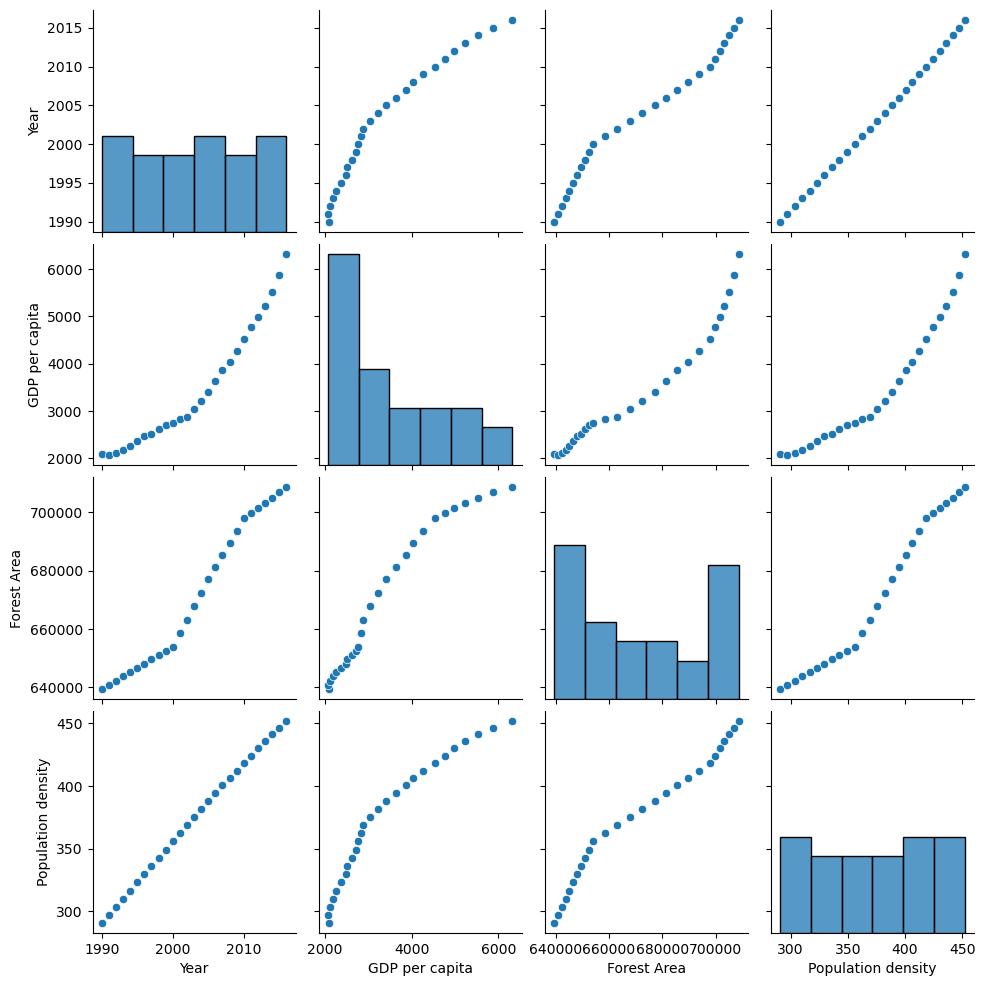

In [91]:
sns.pairplot(added_population_merged_df_india)

### Splitting India Data

Splitting India data into training and testing sets.

In [93]:
added_population_train_size_india = int(split_by * added_population_merged_df_india.shape[0])
added_population_training_india, added_population_test_india = added_population_merged_df_india.iloc[:added_population_train_size_india], added_population_merged_df_india.iloc[added_population_train_size_india:]

## Bayesian Modeling: India (GDP + Population Density)

Building and simulating a Bayesian regression model for India using GDP per capita and population density as predictors for forest area.

In [95]:
with pm.Model() as forest_india_added_population_regression_model:
    gdp = pm.Data("gdp", added_population_training_india["GDP per capita"], dims="obs")
    population = pm.Data("population", added_population_training_india["Population density"], dims="obs")

    # priors
    beta_b = pm.HalfNormal("sigma", sigma=10)
    beta_i = pm.Normal("beta_i", mu=0, sigma=100000)
    beta_gdp = pm.Normal("beta_gdp", mu=0, sigma=1000)
    beta_population = pm.Normal("beta_population", mu=0, sigma=1000)

    # likelihood
    pm.Normal("Forest Area", mu=beta_i + beta_gdp * gdp + beta_population * population, sigma=beta_b, observed=added_population_training_india["Forest Area"], dims="obs")

### Model Simulation and Analysis

Sampling from the posterior distribution, assessing model convergence, and visualizing results.

In [ ]:
with forest_india_added_population_regression_model:
    ipdata = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta_i, beta_gdp, beta_population]


Output()

Output()

In [ ]:
ipdata

In [ ]:
az.summary(ipdata)

In [ ]:
az.plot_energy(ipdata)

In [ ]:
az.plot_trace(ipdata, figsize=(20, 20))

In [ ]:
az.plot_posterior(ipdata, var_names=["beta_i", "beta_gdp", "sigma", "beta_population"])

### Model Prediction and Evaluation

Predicting forest area on the test set and evaluating model performance.

In [ ]:
ipdata.posterior["y_model"] = ipdata.posterior["beta_i"] + ipdata.posterior["beta_gdp"] * xr.DataArray(added_population_training_india["GDP per capita"]) +  ipdata.posterior["beta_population"] * xr.DataArray(added_population_training_india["Population density"])

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=ipdata, y="Forest Area", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

# Predicting values for test data (India) using model

In [ ]:
with forest_india_added_population_regression_model:
    pm.set_data({"gdp" : added_population_test_india["GDP per capita"], "population" : added_population_test_india["Population density"]})
    ipdata.extend(pm.sample_posterior_predictive(ipdata))

In [ ]:
ipdata

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(y=added_population_test_india["Forest Area"], num_samples=100, axes=ax, y_model=ipdata.posterior_predictive["Forest Area"])
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

### Exploring Data: United States (Population Density)

Plotting pairplot to see correlations between columns for the United States, including population density.

In [ ]:
added_population_merged_df_usa = added_population_merged__df.loc[added_population_merged__df["Entity"] == "United States"]
added_population_merged_df_usa

In [ ]:
sns.pairplot(added_population_merged_df_usa)

### Splitting USA Data

Splitting USA data into training and testing sets.

In [ ]:
added_population_train_size_usa = int(split_by * added_population_merged_df_usa.shape[0])
added_population_training_usa, added_population_test_usa = added_population_merged_df_usa.iloc[:added_population_train_size_usa], added_population_merged_df_usa.iloc[added_population_train_size_usa:]

## Bayesian Modeling: USA (GDP + Population Density)

Building and simulating a Bayesian regression model for the USA using GDP per capita and population density as predictors for forest area.

In [ ]:
with pm.Model() as forest_usa_added_population_regression_model:
    gdp = pm.Data("gdp", added_population_training_usa["GDP per capita"], dims="obs")
    population = pm.Data("population", added_population_training_usa["Population density"], dims="obs")

    # priors
    beta_b = pm.HalfNormal("sigma", sigma=10)
    beta_i = pm.Normal("beta_i", mu=0, sigma=100000)
    beta_gdp = pm.Normal("beta_gdp", mu=0, sigma=1000)
    beta_population = pm.Normal("beta_population", mu=0, sigma=1000)

    # likelihood
    pm.Normal("Forest Area", mu=beta_i + beta_gdp * gdp + beta_population * population, sigma=beta_b, observed=added_population_training_usa["Forest Area"], dims="obs")

### Model Simulation and Analysis

Sampling from the posterior distribution, assessing model convergence, and visualizing results.

In [ ]:
with forest_usa_added_population_regression_model:
    updata = pm.sample(1000, tune=2000, cores=1)

In [ ]:
updata

In [ ]:
az.summary(updata)

In [ ]:
az.plot_energy(updata)

In [ ]:
az.plot_trace(updata, figsize=(20, 20))

In [ ]:
az.plot_posterior(updata, var_names=["beta_i", "beta_gdp", "sigma", "beta_population"])

### Model Prediction and Evaluation

Predicting forest area on the test set and evaluating model performance.

In [ ]:
updata.posterior["y_model"] = updata.posterior["beta_i"] + updata.posterior["beta_gdp"] * xr.DataArray(added_population_training_usa["GDP per capita"]) +  updata.posterior["beta_population"] * xr.DataArray(added_population_training_usa["Population density"])

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=updata, y="Forest Area", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

# Predicting values for test data (Usa) using model

In [ ]:
with forest_usa_added_population_regression_model:
    pm.set_data({"gdp" : added_population_test_usa["GDP per capita"], "population" : added_population_test_usa["Population density"]})
    updata.extend(pm.sample_posterior_predictive(updata))

In [ ]:
updata

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(y=added_population_test_usa["Forest Area"], num_samples=100, axes=ax, y_model=updata.posterior_predictive["Forest Area"])
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

### Loading Urban Area Dataset

In [ ]:
urban_df = pd.read_csv("urban-area-long-term.csv")
urban_df

### Merging Urban Area Data

Merging urban area data with the existing dataset.

In [ ]:
added_urban_merged_df = pd.merge(added_population_merged__df, urban_df, on=['Entity', 'Year'], how='inner')
added_urban_merged_df

### Dropping Unnecessary Columns

Removing columns not required for the analysis.

In [ ]:
added_urban_merged_df.drop("Code", axis=1, inplace=True)
added_urban_merged_df

### Data Information

Checking information of each column.

In [ ]:
added_urban_merged_df.info()

In [ ]:
added_urban_merged_df["Entity"].unique()

### Exploring Data: India (Urban Area)

Plotting pairplot to see correlations between columns for India, including urban area.

In [ ]:
added_urban_merged_df_india = added_urban_merged_df.loc[added_urban_merged_df["Entity"] == "India"]
added_urban_merged_df_india

In [ ]:
sns.pairplot(added_urban_merged_df_india)

### Splitting India Data

Splitting India data into training and testing sets.

In [ ]:
added_urban_train_size_india = int(split_by * added_urban_merged_df_india.shape[0])
added_urban_training_india, added_urban_test_india = added_urban_merged_df_india.iloc[:added_urban_train_size_india], added_urban_merged_df_india.iloc[added_urban_train_size_india:]

## Bayesian Modeling: India (GDP + Population Density + Urban Area)

Building and simulating a Bayesian regression model for India using GDP per capita, population density, and urban area as predictors for forest area.

In [ ]:
with pm.Model() as forest_india_added_urban_regression_model:
    gdp = pm.Data("gdp", added_urban_training_india["GDP per capita"], dims="obs")
    population = pm.Data("population", added_urban_training_india["Population density"], dims="obs")
    urban_area = pm.Data("urban_area", added_urban_training_india["Land use: Built-up area"], dims="obs")

    # priors
    beta_b = pm.HalfNormal("sigma", sigma=10)
    beta_i = pm.Normal("beta_i", mu=0, sigma=100000)
    beta_gdp = pm.Normal("beta_gdp", mu=0, sigma=1000)
    beta_population = pm.Normal("beta_population", mu=0, sigma=1000)
    beta_urban = pm.Normal("beta_urban", mu=0, sigma=1000)

    # likelihood
    pm.Normal("Forest Area", mu=beta_i + beta_gdp * gdp + beta_population * population + beta_urban * urban_area, sigma=beta_b, observed=added_urban_training_india["Forest Area"], dims="obs")

### Model Simulation and Analysis

Sampling from the posterior distribution, assessing model convergence, and visualizing results.

In [ ]:
with forest_india_added_urban_regression_model:
    iudata = pm.sample(1000, tune=2000, cores=1)

In [ ]:
iudata

In [ ]:
az.summary(iudata)

In [ ]:
az.plot_energy(iudata)

In [ ]:
az.plot_trace(iudata, figsize=(20, 20))

In [ ]:
az.plot_posterior(iudata, var_names=["beta_i", "beta_gdp", "sigma", "beta_population", "beta_urban"])

### Model Prediction and Evaluation

Predicting forest area on the test set and evaluating model performance.

In [ ]:
iudata.posterior["y_model"] = iudata.posterior["beta_i"] + iudata.posterior["beta_gdp"] * xr.DataArray(added_urban_training_india["GDP per capita"]) +  iudata.posterior["beta_population"] * xr.DataArray(added_urban_training_india["Population density"]) + iudata.posterior["beta_urban"] * xr.DataArray(added_urban_training_india["Land use: Built-up area"])

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=iudata, y="Forest Area", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

# Predicting values for test data (India) using model

In [ ]:
with forest_india_added_urban_regression_model:
    pm.set_data({"gdp" : added_urban_test_india["GDP per capita"], "population" : added_urban_test_india["Population density"], "urban_area" : added_urban_test_india["Land use: Built-up area"]})
    iudata.extend(pm.sample_posterior_predictive(iudata))

In [ ]:
iudata

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(y=added_urban_test_india["Forest Area"], num_samples=100, axes=ax, y_model=iudata.posterior_predictive["Forest Area"])
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

### Exploring Data: United States (Urban Area)

Plotting pairplot to see correlations between columns for the United States, including urban area.

In [ ]:
added_urban_merged_df_us = added_urban_merged_df.loc[added_urban_merged_df["Entity"] == "United States"]
added_urban_merged_df_us

In [ ]:
sns.pairplot(added_urban_merged_df_us)

### Splitting USA Data

Splitting USA data into training and testing sets.

In [ ]:
added_urban_train_size_usa = int(split_by * added_urban_merged_df_us.shape[0])
added_urban_training_usa, added_urban_test_usa = added_urban_merged_df_us.iloc[:added_urban_train_size_usa], added_urban_merged_df_us.iloc[added_urban_train_size_usa:]

## Bayesian Modeling: USA (GDP + Population Density + Urban Area)

Building and simulating a Bayesian regression model for the USA using GDP per capita, population density, and urban area as predictors for forest area.

In [ ]:
with pm.Model() as forest_usa_added_urban_regression_model:
    gdp = pm.Data("gdp", added_urban_training_usa["GDP per capita"], dims="obs")
    population = pm.Data("population", added_urban_training_usa["Population density"], dims="obs")
    urban_area = pm.Data("urban_area", added_urban_training_usa["Land use: Built-up area"], dims="obs")

    # priors
    beta_b = pm.HalfNormal("sigma", sigma=10)
    beta_i = pm.Normal("beta_i", mu=0, sigma=100000)
    beta_gdp = pm.Normal("beta_gdp", mu=0, sigma=1000)
    beta_population = pm.Normal("beta_population", mu=0, sigma=1000)
    beta_urban = pm.Normal("beta_urban", mu=0, sigma=10000)

    # likelihood
    pm.Normal("Forest Area", mu=beta_i + beta_gdp * gdp + beta_population * population + beta_urban * urban_area, sigma=beta_b, observed=added_urban_training_usa["Forest Area"], dims="obs")

### Model Simulation and Analysis

Sampling from the posterior distribution, assessing model convergence, and visualizing results.

In [ ]:
with forest_usa_added_urban_regression_model:
    uudata = pm.sample(1000, tune=2000, cores=1)

In [ ]:
uudata

In [ ]:
az.summary(uudata)

In [ ]:
az.plot_energy(uudata)

In [ ]:
az.plot_trace(uudata, figsize=(20, 20))

In [ ]:
az.plot_posterior(uudata, var_names=["beta_i", "beta_gdp", "sigma", "beta_population", "beta_urban"])

### Model Prediction and Evaluation

Predicting forest area on the test set and evaluating model performance.

In [ ]:
uudata.posterior["y_model"] = uudata.posterior["beta_i"] + uudata.posterior["beta_gdp"] * xr.DataArray(added_urban_training_usa["GDP per capita"]) +  uudata.posterior["beta_population"] * xr.DataArray(added_urban_training_usa["Population density"]) + uudata.posterior["beta_urban"] * xr.DataArray(added_urban_training_usa["Land use: Built-up area"])

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=uudata, y="Forest Area", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

# Predicting values for test data (Usa) using model

In [ ]:
with forest_usa_added_urban_regression_model:
    pm.set_data({"gdp" : added_urban_test_usa["GDP per capita"], "population" : added_urban_test_usa["Population density"], "urban_area" : added_urban_test_usa["Land use: Built-up area"]})
    uudata.extend(pm.sample_posterior_predictive(uudata))

In [ ]:
uudata

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(y=added_urban_test_usa["Forest Area"], num_samples=100, axes=ax, y_model=uudata.posterior_predictive["Forest Area"])
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")